## UFO Sightings Data Preparation

The goal of this notebook is to build out models to use for predicting the legitimacy of a UFO sighting. 

What we plan on accompishling is the following:
1. [Load dataset onto Notebook instance memory from S3](#Step-1:-Load-the-data-from-Amazon-S3)
1. [Cleaning, transforming, analyize, and preparing the dataset](#Step-2:-Cleaning,-transforming,-analyize,-and-preparing-the-dataset)
1. [Create and train our model (XGBoost)](#Step-3:-Creating-and-training-our-model-(XGBoost))
1. [Create and train our model (Linear Learner)](#Step-4:-Creating-and-training-our-model-(Linear-Learner))

First let's go ahead and import all the needed libraries.

In [251]:
import pandas as pd
import numpy as np
from datetime import datetime
import io
import sagemaker.amazon.common as smac

import boto3
from sagemaker import get_execution_role
import sagemaker

import matplotlib.pyplot as plt
import seaborn as sns

## Step 1: Loading the data from Amazon S3
Lets get the UFO sightings data that is stored in S3 and load it into memory.

In [252]:
role = get_execution_role()
bucket='<INSERT_BUCKET_NAME_HERE>'
sub_folder = 'ufo_dataset'
data_key = 'ufo_fullset.csv'
data_location = 's3://{}/{}/{}'.format(bucket, sub_folder, data_key)

df = pd.read_csv(data_location, low_memory=False)
df.head()

,reportedTimestamp,eventDate,eventTime,duration,witnesses,weather,firstName,lastName,latitude,longitude,sighting,physicalEvidence,contact,researchOutcome,shape
0,2009-09-14T04:08:11.873Z,2009-09-13,23:56,21,1,snow,Devon,Blanda,33.248611,-111.633611,Y,N,N,explained,disk
1,1983-11-24T23:25:55.499Z,1983-11-23,14:23,77,1,fog,Cooper,Littel,29.369722,47.978333,Y,N,N,explained,circle
2,2009-05-24T17:38:30.661Z,2009-05-21,15:48,98,1,rain,Moises,Fisher,30.294722,-82.984167,Y,N,N,probable,triangle
3,1975-08-21T15:07:53.327Z,1975-08-20,15:32,22,1,partly cloudy,Annabell,Hand,45.263056,-122.691389,Y,N,N,explained,circle
4,2016-07-25T19:25:28.122Z,2016-07-18,13:06,29,1,stormy,Joesph,Toy,31.891111,-85.145556,Y,N,N,explained,circle


<hr>

## Step 2: Cleaning, transforming, analyize, and preparing the dataset
This step is so important. It's crucial that we clean and prepare our data before we do anything else.

In [253]:
# Let's check to see if there are any missing values
missing_values = df.isnull().values.any()
if(missing_values):
    display(df[df.isnull().any(axis=1)])

,reportedTimestamp,eventDate,eventTime,duration,witnesses,weather,firstName,lastName,latitude,longitude,sighting,physicalEvidence,contact,researchOutcome,shape
1024,1996-09-17T06:32:46.132Z,1996-09-16,09:44,1,1,fog,Ike,Lueilwitz,54.200000,-5.883333,Y,N,N,explained,NaN
2048,1997-03-19T04:53:00.772Z,1997-03-16,09:11,72,2,fog,Idella,Wintheiser,33.598056,-117.872222,Y,N,N,explained,NaN


In [254]:
df['shape'].value_counts()

disk        6230
circle      6214
light       1768
square      1732
triangle    1051
sphere      1003
Name: shape, dtype: int64

In [255]:
# Replace the missing values with the most common shape
df['shape'] = df['shape'].fillna(df['shape'].value_counts().index[0])

Let's go ahead and start preparing our dataset by transforming some of the values into the correct data types. Here is what we are going to take care of.
1. Convert the `reportedTimestamp` and `eventDate` to a datetime data types.
1. Convert the `shape` and `weather` to a category data type.
1. Map the `physicalEvidence` and `contact` from 'Y', 'N' to `0`, `1`.
1. Convert the `researchOutcome` to a category data type (target attribute).

In [256]:
df['reportedTimestamp'] = pd.to_datetime(df['reportedTimestamp'])
df['eventDate'] = pd.to_datetime(df['eventDate'])

df['shape'] = df['shape'].astype('category')
df['weather'] = df['weather'].astype('category')

df['physicalEvidence'] = df['physicalEvidence'].replace({'Y': 1, 'N': 0})
df['contact'] = df['contact'].replace({'Y': 1, 'N': 0})

df['researchOutcome'] = df['researchOutcome'].astype('category')

In [257]:
df.dtypes

reportedTimestamp    datetime64[ns]
eventDate            datetime64[ns]
eventTime                    object
duration                      int64
witnesses                     int64
weather                    category
firstName                    object
lastName                     object
latitude                    float64
longitude                   float64
sighting                     object
physicalEvidence              int64
contact                       int64
researchOutcome            category
shape                      category
dtype: object

Let's visualize some of the data to see if we can find out any important information.

In [258]:
%matplotlib inline
sns.set_context("paper", font_scale=1.4)

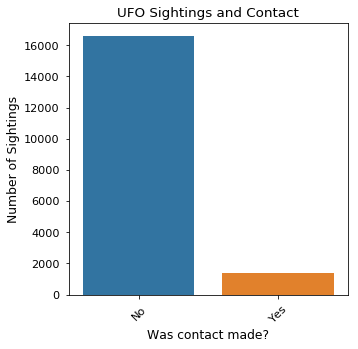

In [259]:
m_cts = (df['contact'].value_counts())
m_ctsx = m_cts.index
m_ctsy = m_cts.get_values()
f, ax = plt.subplots(figsize=(5,5))

sns.barplot(x=m_ctsx, y=m_ctsy)
ax.set_title('UFO Sightings and Contact')
ax.set_xlabel('Was contact made?')
ax.set_ylabel('Number of Sightings')
ax.set_xticklabels(['No', 'Yes'])
plt.xticks(rotation=45)
plt.show()

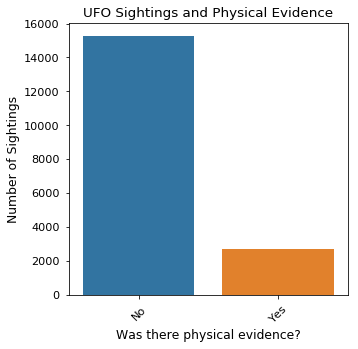

In [260]:
m_cts = (df['physicalEvidence'].value_counts())
m_ctsx = m_cts.index
m_ctsy = m_cts.get_values()
f, ax = plt.subplots(figsize=(5,5))

sns.barplot(x=m_ctsx, y=m_ctsy)
ax.set_title('UFO Sightings and Physical Evidence')
ax.set_xlabel('Was there physical evidence?')
ax.set_ylabel('Number of Sightings')
ax.set_xticklabels(['No', 'Yes'])
plt.xticks(rotation=45)
plt.show()

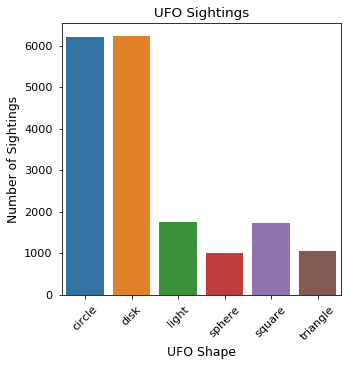

In [261]:
m_cts = (df['shape'].value_counts())
m_ctsx = m_cts.index
m_ctsy = m_cts.get_values()
f, ax = plt.subplots(figsize=(5,5))

sns.barplot(x=m_ctsx, y=m_ctsy)
ax.set_title('UFO Sightings')
ax.set_xlabel('UFO Shape')
ax.set_ylabel('Number of Sightings')
plt.xticks(rotation=45)
plt.show()

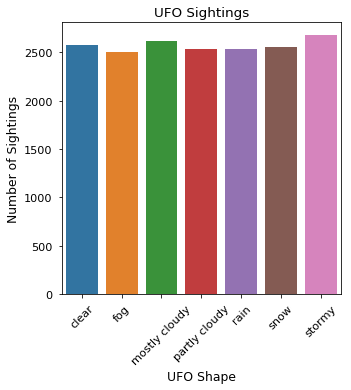

In [262]:
m_cts = (df['weather'].value_counts())
m_ctsx = m_cts.index
m_ctsy = m_cts.get_values()
f, ax = plt.subplots(figsize=(5,5))

sns.barplot(x=m_ctsx, y=m_ctsy)
ax.set_title('UFO Sightings')
ax.set_xlabel('UFO Shape')
ax.set_ylabel('Number of Sightings')
plt.xticks(rotation=45)
plt.show()

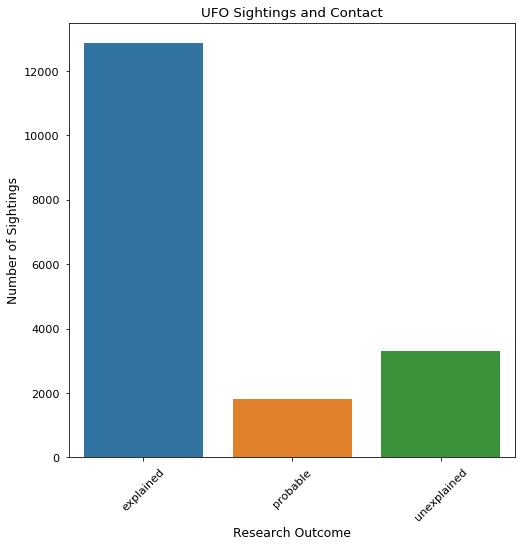

In [263]:
m_cts = (df['researchOutcome'].value_counts())
m_ctsx = m_cts.index
m_ctsy = m_cts.get_values()
f, ax = plt.subplots(figsize=(5,5))

sns.barplot(x=m_ctsx, y=m_ctsy)
ax.set_title('UFO Sightings and Contact')
ax.set_xlabel('Research Outcome')
ax.set_ylabel('Number of Sightings')
# ax.set_xticklabels(['Unexplained', 'Explained', 'Probable'])
plt.xticks(rotation=45)
plt.show()

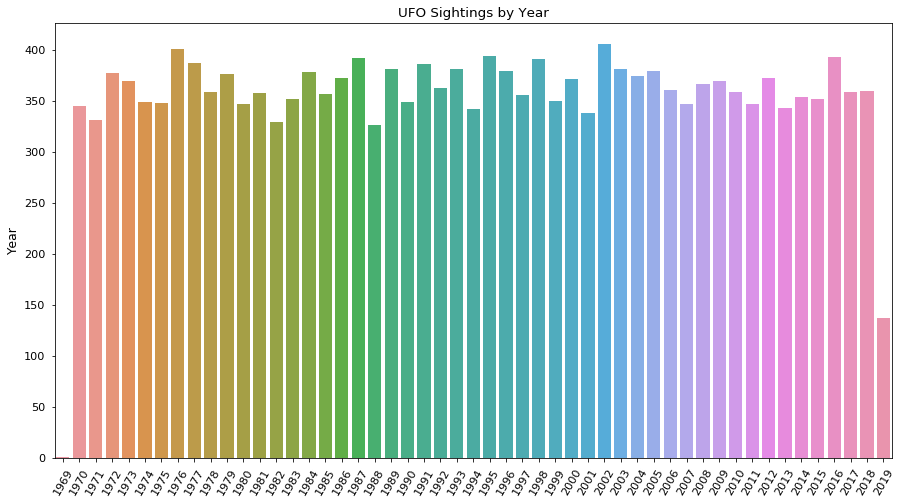

In [264]:
ufo_yr = df['eventDate'].dt.year  # series with the year exclusively

## Set axes ##
years_data = ufo_yr.value_counts()
years_index = years_data.index  # x ticks
years_values = years_data.get_values()

## Create Bar Plot ##
plt.figure(figsize=(15,8))
plt.xticks(rotation = 60)
plt.title('UFO Sightings by Year')
plt.ylabel('Number of Sightings')
plt.ylabel('Year')

years_plot = sns.barplot(x=years_index[:60],y=years_values[:60])

Let's drop the columns that are not important. 
1. We can drop `sighting` becuase it is always 'Y' or Yes. 
1. Let's drop the `firstName` and `lastName` becuase they are not important in determining the `researchOutcome`.
1. Let's srop the `reportedTimestamp` becuase when the sighting was reporting isn't going to help us determine the legitimacy of the sighting.
1. We would need to create some sort of buckets for the `eventDate` and `eventTime`, like seasons for example, but since the distributionn of dates is pretty even, lets go ahead and drop them.

In [265]:
df.drop(columns=['firstName', 'lastName', 'sighting', 'reportedTimestamp', 'eventDate', 'eventTime'], inplace=True)

In [266]:
df.head()

,duration,witnesses,weather,latitude,longitude,physicalEvidence,contact,researchOutcome,shape
0,21,1,snow,33.248611,-111.633611,0,0,explained,disk
1,77,1,fog,29.369722,47.978333,0,0,explained,circle
2,98,1,rain,30.294722,-82.984167,0,0,probable,triangle
3,22,1,partly cloudy,45.263056,-122.691389,0,0,explained,circle
4,29,1,stormy,31.891111,-85.145556,0,0,explained,circle


Let's apply one-hot encoding
1. We need to one-hot both the `weather` attribute and the `shape` attribute. 
1. We also need to transform or map the researchOutcome (target) attribute into numeric values. This is what the alogrithm is expecting. We can do this by mapping unexplained, explained, and probable to 0, 1, 2.

In [267]:
# Lets one-hot the weather and shape attribute
df = pd.get_dummies(df, columns=['weather', 'shape'])

# Lets replace the researchOutcome values with 0, 1, 2 for Unexplained, Explained, and Probable
df['researchOutcome'] = df['researchOutcome'].replace({'unexplained': 0, 'explained': 1, 'probable': 2})

In [268]:
display(df.head())
display(df.shape)

,duration,witnesses,latitude,longitude,physicalEvidence,contact,researchOutcome,weather_clear,weather_fog,weather_mostly cloudy,weather_partly cloudy,weather_rain,weather_snow,weather_stormy,shape_circle,shape_disk,shape_light,shape_sphere,shape_square,shape_triangle
0,21,1,33.248611,-111.633611,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0
1,77,1,29.369722,47.978333,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0
2,98,1,30.294722,-82.984167,0,0,2,0,0,0,0,1,0,0,0,0,0,0,0,1
3,22,1,45.263056,-122.691389,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0
4,29,1,31.891111,-85.145556,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0


(18000, 20)

<hr>

Let's randomize and split the data into training, validation, and testing.
1. First we need to randomize the data.
1. Next lets use 80% of the dataset for our training set.
1. Then use 10% for validation during training.
1. Finally we will use 10% for testing our model after it is deployed.

In [269]:
# Lets go ahead and randomize our data.
df = df.sample(frac=1).reset_index(drop=True)

# Next, lets split the data into a training, validation, and testing.
rand_split = np.random.rand(len(df))
train_list = rand_split < 0.8                       # 80% for training
val_list = (rand_split >= 0.8) & (rand_split < 0.9) # 10% for validation
test_list = rand_split >= 0.9                       # 10% for testing

 # This dataset will be used to train the model.
data_train = df[train_list]

# This dataset will be used to validate the model.
data_val = df[val_list]

# This dataset will be used to test the model.
data_test = df[test_list]

Next, let's go ahead and rearrange our attributes so the first attribute is our target attribute `researchOutcome`. This is what AWS requires and the XGBoost algorithms expects. You can read all about it here in the [documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/xgboost.html#InputOutput-XGBoost).

After that we will go ahead and create those files on our Notebook instance (stored as CSV) and then upload them to S3. 

In [270]:
# Simply moves the researchOutcome attribute to the first position before creating CSV files
pd.concat([data_train['researchOutcome'], data_train.drop(['researchOutcome'], axis=1)], axis=1).to_csv('train.csv', index=False, header=False)
pd.concat([data_val['researchOutcome'], data_val.drop(['researchOutcome'], axis=1)], axis=1).to_csv('validation.csv', index=False, header=False)

# Next we can take the files we just stored onto our Notebook instance and upload them to S3.
boto3.Session().resource('s3').Bucket(bucket).Object('algorithms_lab/xgboost_train/train.csv').upload_file('train.csv')
boto3.Session().resource('s3').Bucket(bucket).Object('algorithms_lab/xgboost_validation/validation.csv').upload_file('validation.csv')


<hr>

## Step 3: Creating and training our model (XGBoost)

This is where the magic happens. We will get the ECR container hosted in ECR for the XGBoost algorithm. 

In [271]:
from sagemaker.amazon.amazon_estimator import get_image_uri
container = get_image_uri(boto3.Session().region_name, 'xgboost')

Next, because we're training with the CSV file format, we'll create inputs that our training function can use as a pointer to the files in S3, which also specify that the content type is CSV.

In [272]:
s3_input_train = sagemaker.s3_input(s3_data='s3://{}/algorithms_lab/xgboost_train'.format(bucket), content_type='csv')
s3_input_validation = sagemaker.s3_input(s3_data='s3://{}/algorithms_lab/xgboost_validation'.format(bucket), content_type='csv')


<hr>

Next we start building out our model by using the SageMaker Pyhton SDK and passing in everything that is required to create a XGBoost model.

First I like to always create a specific job name.

Next, we'll need to specify training parameters.
1. The `xgboost` algorithm container
1. The IAM role to use
1. Training instance type and count
1. S3 location for output data/model artifact
1. [XGBoost Hyperparameters](https://docs.aws.amazon.com/sagemaker/latest/dg/xgboost_hyperparameters.html)


Finally, after everything is included and ready, then we can call the `.fit()` function which specifies the S3 location for training and validation data.

In [273]:
# Create a training job name
job_name = 'ufo-xgboost-job-{}'.format(datetime.now().strftime("%Y%m%d%H%M%S"))
print('Here is the job name {}'.format(job_name))

# Here is where the model artifact will be stored
output_location = 's3://{}/algorithms_lab/xgboost_output'.format(bucket)

Here is the job name ufo-xgboost-job-20190522235646


In [274]:
sess = sagemaker.Session()

xgb = sagemaker.estimator.Estimator(container,
                                    role, 
                                    train_instance_count=1, 
                                    train_instance_type='ml.m4.xlarge',
                                    output_path=output_location,
                                    sagemaker_session=sess)

xgb.set_hyperparameters(objective='multi:softmax',
                        num_class=3,
                        num_round=100)

data_channels = {
    'train': s3_input_train,
    'validation': s3_input_validation
}
xgb.fit(data_channels, job_name=job_name) 

2019-05-22 23:56:47 Starting - Starting the training job...
2019-05-22 23:56:51 Starting - Launching requested ML instances......
2019-05-22 23:57:57 Starting - Preparing the instances for training.........
2019-05-22 23:59:48 Downloading - Downloading input data
2019-05-22 23:59:48 Training - Downloading the training image..
Arguments: train
[2019-05-22:23:59:52:INFO] Running standalone xgboost training.
[2019-05-22:23:59:52:INFO] File size need to be processed in the node: 0.99mb. Available memory size in the node: 8437.62mb
[2019-05-22:23:59:52:INFO] Determined delimiter of CSV input is ','
[23:59:52] S3DistributionType set as FullyReplicated
[23:59:52] 14413x19 matrix with 273847 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[2019-05-22:23:59:52:INFO] Determined delimiter of CSV input is ','
[23:59:52] S3DistributionType set as FullyReplicated
[23:59:52] 1835x19 matrix with 34865 entries loaded from /opt/ml/input/data/validation?format=csv&label

After we train our model we can see the default evaluation metric in the logs. The `merror` is used in multiclass classification error rate. It is calculated as #(wrong cases)/#(all cases). We want this to be minimized (so we want this to be super small).

---

## Step 4: Creating and training our model (Linear Learner)

Let's evaluate the Linear Learner algorithm as well. Let's go ahead and randomize the data again and get it ready for the Linear Leaner algorithm. We will also rearrange the columns so it is ready for the algorithm (it expects the first column to be the target attribute)

In [316]:
np.random.seed(0)
rand_split = np.random.rand(len(df))
train_list = rand_split < 0.8
val_list = (rand_split >= 0.8) & (rand_split < 0.9)
test_list = rand_split >= 0.9

 # This dataset will be used to train the model.
data_train = df[train_list]

# This dataset will be used to validate the model.
data_val = df[val_list]

# This dataset will be used to test the model.
data_test = df[test_list]

# This rearranges the columns
cols = list(data_train)
cols.insert(0, cols.pop(cols.index('researchOutcome')))
data_train = data_train[cols]

cols = list(data_val)
cols.insert(0, cols.pop(cols.index('researchOutcome')))
data_val = data_val[cols]

cols = list(data_test)
cols.insert(0, cols.pop(cols.index('researchOutcome')))
data_test = data_test[cols]

# Breaks the datasets into attribute numpy.ndarray and the same for target attribute.  
train_X = data_train.drop(columns='researchOutcome').as_matrix()
train_y = data_train['researchOutcome'].as_matrix()

val_X = data_val.drop(columns='researchOutcome').as_matrix()
val_y = data_val['researchOutcome'].as_matrix()

test_X = data_test.drop(columns='researchOutcome').as_matrix()
test_y = data_test['researchOutcome'].as_matrix()

Next, lets create recordIO file for the training data and upload it to S3.

In [317]:
train_file = 'ufo_sightings_train_recordIO_protobuf.data'

f = io.BytesIO()
smac.write_numpy_to_dense_tensor(f, train_X.astype('float32'), train_y.astype('float32'))
f.seek(0)

boto3.Session().resource('s3').Bucket(bucket).Object('algorithms_lab/linearlearner_train/{}'.format(train_file)).upload_fileobj(f)
training_recordIO_protobuf_location = 's3://{}/algorithms_lab/linearlearner_train/{}'.format(bucket, train_file)
print('The Pipe mode recordIO protobuf training data: {}'.format(training_recordIO_protobuf_location))

The Pipe mode recordIO protobuf training data: s3://ml-modeling-lab/algorithms_lab/linearlearner_train/ufo_sightings_train_recordIO_protobuf.data


Lets create recordIO file for the validation data and upload it to S3

In [318]:
validation_file = 'ufo_sightings_validatioin_recordIO_protobuf.data'

f = io.BytesIO()
smac.write_numpy_to_dense_tensor(f, val_X.astype('float32'), val_y.astype('float32'))
f.seek(0)

boto3.Session().resource('s3').Bucket(bucket).Object('algorithms_lab/linearlearner_validation/{}'.format(validation_file)).upload_fileobj(f)
validate_recordIO_protobuf_location = 's3://{}/algorithms_lab/linearlearner_validation/{}'.format(bucket, validation_file)
print('The Pipe mode recordIO protobuf validation data: {}'.format(validate_recordIO_protobuf_location))

The Pipe mode recordIO protobuf validation data: s3://ml-modeling-lab/algorithms_lab/linearlearner_validation/ufo_sightings_validatioin_recordIO_protobuf.data


---

Alright we are good to go for the Linear Learner algorithm. Let's get everything we need from the ECR repository to call the Linear Learner algorithm.

In [319]:
from sagemaker.amazon.amazon_estimator import get_image_uri
import sagemaker

container = get_image_uri(boto3.Session().region_name, 'linear-learner', "1")

In [320]:
# Create a training job name
job_name = 'ufo-linear-learner-job-{}'.format(datetime.now().strftime("%Y%m%d%H%M%S"))
print('Here is the job name {}'.format(job_name))

# Here is where the model-artifact will be stored
output_location = 's3://{}/algorithms_lab/linearlearner_output'.format(bucket)

Here is the job name ufo-linear-learner-job-20190523001439


Next we start building out our model by using the SageMaker Pyhton SDK and passing in everything that is required to create a Linear Learner model.

First I like to always create a specific job name.

Next, we'll need to specify training parameters.
1. The `xgboost` algorithm container
1. The IAM role to use
1. Training instance type and count
1. S3 location for output data/model artifact
1. [The input type (Pipe)](https://docs.aws.amazon.com/sagemaker/latest/dg/linear-learner.html)
1. [Linear Learner Hyperparameters](https://docs.aws.amazon.com/sagemaker/latest/dg/ll_hyperparameters.html)


Finally, after everything is included and ready, then we can call the `.fit()` function which specifies the S3 location for training and validation data.

In [321]:
sess = sagemaker.Session()

# Setup the LinearLeaner algorithm from the ECR container
linear = sagemaker.estimator.Estimator(container,
                                       role, 
                                       train_instance_count=1, 
                                       train_instance_type='ml.c4.xlarge',
                                       output_path=output_location,
                                       sagemaker_session=sess,
                                       input_mode='Pipe')
# Setup the hyperparameters
linear.set_hyperparameters(feature_dim=19, # number of attributes (minus the researchOutcome attribute)
                           predictor_type='multiclass_classifier', # type of classification problem
                           num_classes=3)  # number of classes in out researchOutcome (explained, unexplained, probable)


# Launch a training job. This method calls the CreateTrainingJob API call
data_channels = {
    'train': training_recordIO_protobuf_location,
    'validation': validate_recordIO_protobuf_location
}
linear.fit(data_channels, job_name=job_name)

2019-05-23 00:14:40 Starting - Starting the training job...
2019-05-23 00:14:43 Starting - Launching requested ML instances......
2019-05-23 00:15:52 Starting - Preparing the instances for training.........
2019-05-23 00:17:36 Downloading - Downloading input data..
Docker entrypoint called with argument(s): train
[05/23/2019 00:17:49 INFO 140344101283648] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/default-input.json: {u'loss_insensitivity': u'0.01', u'epochs': u'15', u'init_bias': u'0.0', u'lr_scheduler_factor': u'auto', u'num_calibration_samples': u'10000000', u'accuracy_top_k': u'3', u'_num_kv_servers': u'auto', u'use_bias': u'true', u'num_point_for_scaler': u'10000', u'_log_level': u'info', u'quantile': u'0.5', u'bias_lr_mult': u'auto', u'lr_scheduler_step': u'auto', u'init_method': u'uniform', u'init_sigma': u'0.01', u'lr_scheduler_minimum_lr': u'auto', u'target_recall': u'0.8', u'num_models': u'auto', u'early_stopping_patience': u'3', u'mo

From here we have two trained models to present to Mr. K.. Congratulations!